In [0]:
import numpy as np
import pandas as pd

In [0]:

train_features = pd.read_csv('train/final_with_days_activity.csv')
train_truth = pd.read_csv('train/truth_train.csv', names=['enrollment_id', 'label'])

test_features = pd.read_csv('test/final_with_days_activity.csv')
test_truth = pd.read_csv('test/truth_train.csv', names=['enrollment_id', 'label'])

train_labels = train_truth['label']
test_labels = test_truth['label']

del train_features['enrollment_id']
del test_features['enrollment_id']

del train_features['drop_rate']
del test_features['drop_rate']
del train_features['completion_rate']
del test_features['completion_rate']

In [0]:
from sklearn.utils import resample

def do_sampling(upsampling, train_features, train_truth):
  X_train = train_features
  y_train = train_truth.label

  X = pd.concat([X_train, y_train], axis=1)

  completed = X[X.label==0]
  drop_out = X[X.label==1]

  if upsampling is True:
    sampled = resample(completed,
                          replace=True, # sample with replacement
                          n_samples=len(drop_out), # match number in majority class
                          random_state=27) # reproducible results
    sampled = pd.concat([drop_out, sampled])
  elif upsampling is False:
    sampled = resample(drop_out,
                          replace=False, # sample with replacement
                          n_samples=len(completed), # match number in majority class
                          random_state=27) # reproducible results
    sampled = pd.concat([sampled, completed])
  else:
    X_train = train_features
    y_train = train_truth.label
  
  if upsampling is not None:
    sampled = sampled.sample(frac=1).reset_index(drop=True)
    print(sampled.label.value_counts())
    y_train = sampled.label
    X_train = sampled.drop('label', axis=1)


  return X_train, y_train



In [4]:
# setting up testing and training sets
X_train, y_train = do_sampling(False, train_features, train_truth)
print(X_train.shape)

X_test = test_features
y_test = test_truth.label

1    15029
0    15029
Name: label, dtype: int64
(30058, 113)


In [0]:
# from sklearn import model_selection
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier

# seed = 7
# kfold = model_selection.KFold(n_splits=10)
# cart = DecisionTreeClassifier()
# num_trees = 100
# model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees)
# results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
# print(results.mean())

0.8725895910655833


In [0]:
# from sklearn import model_selection
# from sklearn.ensemble import RandomForestClassifier


# seed = 7
# num_trees = 100
# max_features = 30
# kfold = model_selection.KFold(n_splits=10)
# model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
# results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
# print(results.mean())


0.8727001131074086


In [0]:
# from sklearn import model_selection
# from sklearn.ensemble import ExtraTreesClassifier

# seed = 7
# num_trees = 100
# max_features = 40
# kfold = model_selection.KFold(n_splits=10)
# model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
# results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
# print(results.mean())

0.8694954451753432


In [0]:
# X = array[:,0:8]
# Y = array[:,8]
# seed = 7
# kfold = model_selection.KFold(n_splits=10, random_state=seed)
# # create the sub models
# estimators = []
# model1 = LogisticRegression()
# estimators.append(('logistic', model1))
# model2 = DecisionTreeClassifier()
# estimators.append(('cart', model2))
# model3 = SVC()
# estimators.append(('svm', model3))
# # create the ensemble model
# ensemble = VotingClassifier(estimators)
# results = model_selection.cross_val_score(ensemble, X_train, y_train, cv=kfold)
# print(results.mean())

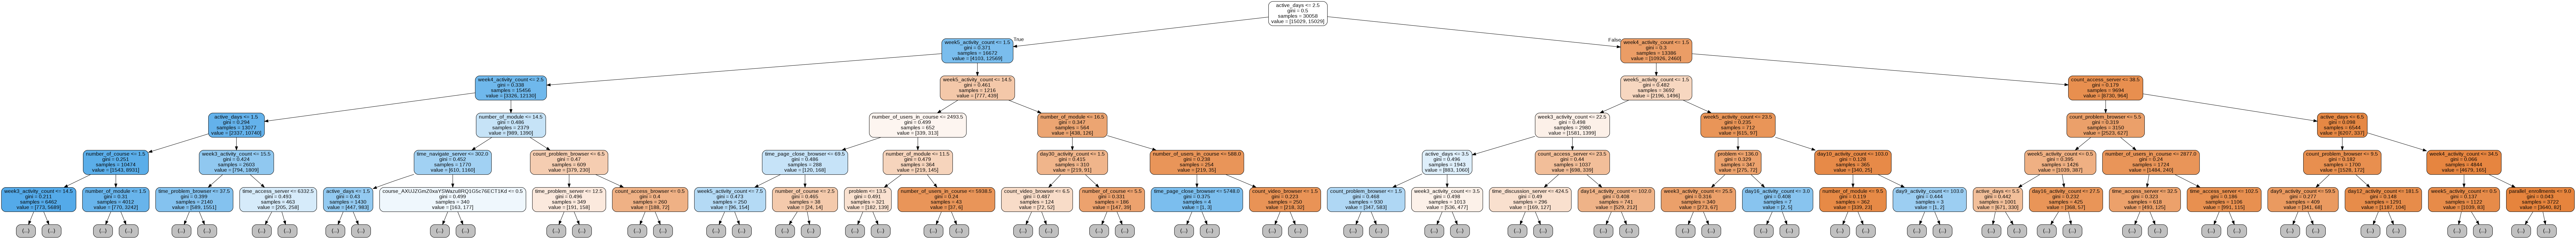

In [5]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import pydot

#data_oh=data_oh.drop(columns=['fnlwgt'])
tree=DecisionTreeClassifier().fit(X_train,y_train)

with open("tree1.dot", 'w') as dot:
    dot = export_graphviz(tree,
                          out_file=dot,
                          max_depth = 5,
                          impurity = True,
                          feature_names = X_train.columns.values,
                          rounded = True,
                          filled= True )

    
# Annotating chart with PIL
(graph,) = pydot.graph_from_dot_file('tree1.dot')

graph.write_png('tree1.png')
PImage('tree1.png')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,active_days,overall_course_completion_rate,about,chapter,course,course_info,html,outlink,problem,sequential,static_tab,vertical,video,combinedopenended,peergrading,discussion,dictation,number_of_course,number_of_module,number_of_users_in_course,time_access_browser,time_access_server,time_navigate_server,time_problem_browser,time_problem_server,time_page_close_browser,time_video_browser,time_discussion_server,time_wiki_server,count_access_browser,count_access_server,count_navigate_server,count_problem_browser,count_problem_server,count_page_close_browser,count_video_browser,count_discussion_server,count_wiki_server,parallel_enrollments,week1_activity_count,...,course_bWdj2GDclj5ofokWjzoa5jAwMkxCykd6,course_fbPkOYLVPtPgIt0MxizjfFJov3JbHyAi,course_gvEwgd64UX4t3K7ftZwXiMkFuxFUAqQE,course_mTmmr5zd8l4wXhwiULwjSmSbi9ktcFmV,course_nSfGxfEtzw5G72fVbfaowxsV46Pg1xIc,course_q6A6QG7qMpyNcznyT2XaIxnfNGkZRxXl,course_shM3Yy9vxHn2aqjSYfQXOcwGo0hWh3MI,course_tXbz2ZYaRyb2ZsWUBPoYzAmisOhHQrYl,course_xMd9DzNyUCTLRPVbwWVzf4vq06oqrTT1,course_ykoe1cCWK134BJmfbNoPEenJOIWdtQOZ,day1_activity_count,day2_activity_count,day3_activity_count,day4_activity_count,day5_activity_count,day6_activity_count,day7_activity_count,day8_activity_count,day9_activity_count,day10_activity_count,day11_activity_count,day12_activity_count,day13_activity_count,day14_activity_count,day15_activity_count,day16_activity_count,day17_activity_count,day18_activity_count,day19_activity_count,day20_activity_count,day21_activity_count,day22_activity_count,day23_activity_count,day24_activity_count,day25_activity_count,day26_activity_count,day27_activity_count,day28_activity_count,day29_activity_count,day30_activity_count
0,0.334878,0.017619,0.0,0.009842,0.001885,0.0,0.0,0.0,0.008882,0.019659,0.0,0.0,0.012259,0.00011,0.0,0.00562,0.0,0.013415,0.023029,0.014836,0.009495,0.031201,0.04188,0.010881,0.007987,0.019754,0.015935,0.010048,0.005756,0.007369,0.024423,0.01554,0.008755,0.004214,0.011796,0.008875,0.006813,0.00338,0.004923,0.008388,...,0.000735,0.000179,0.000391,0.000318,0.000849,0.000564,0.001904,0.000521,0.000566,0.000861,0.004837,0.004807,0.004726,0.006379,0.005038,0.004513,0.004962,0.00532,0.004231,0.004642,0.003725,0.003522,0.005408,0.004677,0.004699,0.004267,0.003046,0.005139,0.003769,0.003254,0.002927,0.004004,0.002501,0.002878,0.004654,0.002862,0.003419,0.004621,0.002,0.003684


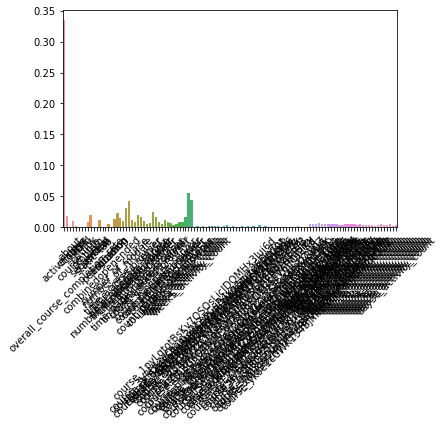

In [6]:
import seaborn as sns

feat_impt=pd.DataFrame(data=tree.feature_importances_).T
feat_impt.columns=X_train.columns.values


feature_importances=pd.DataFrame()
for column in X_train.columns.values:
    value=feat_impt.filter(regex=column)
    value=value.mean(axis=1)
    feature_importances[column]=value

#feature_importances=pd.melt(feature_importances)
p=sns.barplot(data=feature_importances)
p.set_xticklabels(p.get_xticklabels(),rotation=45)
feature_importances

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer',SimpleImputer()),
            ('scaler', StandardScaler()),
            
        ])) # numericals close
    ])),  # features close
])  # pipeline close

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier


estimators=[
    ('logistic',LogisticRegression(solver='liblinear',penalty='l2', max_iter=1000)),
    ('lasso',LogisticRegression(solver='liblinear',penalty='l1', max_iter=1000)),
    ('ridge',RidgeClassifier()),
     ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    ('svc',LinearSVC()),
    ('deep_nn',MLPClassifier(max_iter=1000)),
    ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto'))
]


pipes={}
for model in estimators:
    pipe=Pipeline(steps=[('data_prep',transformer),model])
    pipe.fit(X_train,y_train)
    pipes[pipe.steps[1][0]]=pipe

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss,precision_score, recall_score

_metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss)}


estimator_names=[model[0] for model in estimators]

def plot_estimators(estimators=estimator_names,n_splits=5,metrics=['f1','auc','accuracy','logloss']):
    metrics={key : _metrics[key] for key in metrics}
    scorers=[]
    labels=[]
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe=pipes[pipe_name]
            labels.append(pipe_name)
            kf=KFold(n_splits)
            model_score=cross_validate(pipe,X_train,y_train,scoring=metrics,cv=kf)
            scorers.append(model_score)
    
    score_lists={}
    for metric in metrics:
        score_lists[metric]=[score['test_'+metric] for score in scorers]
    
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)
    return scorers

In [0]:
metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss)}

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

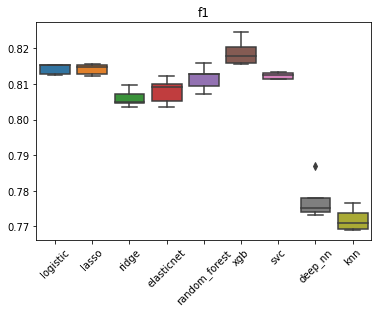

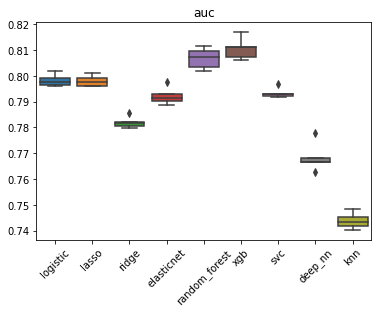

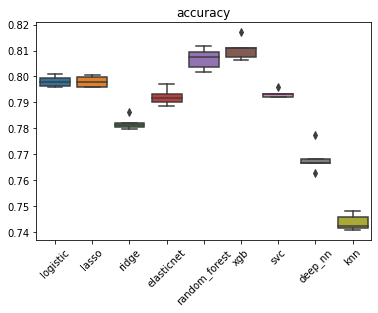

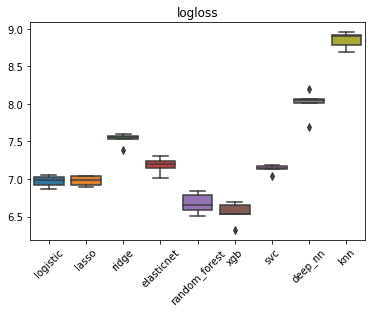

In [14]:
import matplotlib.pyplot as plt

scorers = plot_estimators()

In [0]:

from sklearn.model_selection import GridSearchCV

def tune_param(model,param_grid,refit='auc',chart=None,data=X_train,target=y_train,cv=5):
    
    param_grid={model+'__'+key : param_grid[key] for key in param_grid.keys()}

    gcv=GridSearchCV(pipes[model],param_grid,scoring=metrics,refit=refit,cv=cv)
    gcv.fit(data,target)

    print('best score: '+str(gcv.best_score_))
    print('best params: '+str(gcv.best_params_))
    results=pd.DataFrame(gcv.cv_results_)
    
    if 'line' in chart:
        for i,param in enumerate(param_grid.keys()):
            graph_data=results[['param_'+param,'mean_test_'+refit,'mean_train_'+refit]]
            graph_data=graph_data.rename(columns={'mean_test_'+refit:'test','mean_train_'+refit:'train'})
            graph_data=graph_data.melt('param_'+param, var_name='type',value_name=refit)
            plt.figure(i)
            plot=sns.lineplot(x='param_'+param,y=refit,hue='type',data=graph_data)
            
    if 'heatmap' in chart:
        assert len(param_grid) == 2,  'heatmap only works with 2 params, {} passed'.format(str(len(param_grid)))
        
        param1=list(param_grid.keys())[0]
        param2=list(param_grid.keys())[1]

        graph_data=results[['param_'+param1,'param_'+param2,'mean_test_'+refit]]
        graph_data=graph_data.pivot(index='param_'+param1,columns='param_'+param2,values='mean_test_'+refit)
        sns.heatmap(graph_data,annot=True,xticklabels=True,yticklabels=True).set(xlabel=param2,ylabel=param1)

In [0]:
pipes['logistic'].named_steps['logistic'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

best score: 0.7366559765834773
best params: {'logistic__C': 0.001, 'logistic__tol': 0.01}


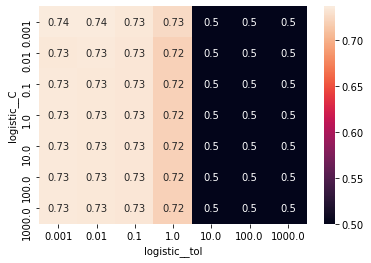

In [0]:
#warnings.filterwarnings('ignore')
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
           'tol':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

tune_param('logistic',param_grid,chart='heatmap')


In [0]:
pipes['logistic'].set_params(**{'logistic__C': 0.001, 'logistic__tol': 0.01})

[{'fit_time': array([1.70548511, 1.69640446, 1.69435287, 1.67823458, 1.70176983]),
  'score_time': array([0.08488417, 0.08390808, 0.08544111, 0.08542562, 0.08596587]),
  'test_accuracy': array([0.79731555, 0.79565956, 0.79604288, 0.79835265, 0.79525843]),
  'test_auc': array([0.79634695, 0.7961882 , 0.79689914, 0.79860392, 0.79461125]),
  'test_f1': array([0.81683929, 0.81417192, 0.8134715 , 0.8156794 , 0.81479145]),
  'test_logloss': array([7.00059251, 7.05779221, 7.04455156, 6.96477184, 7.07164465])}]

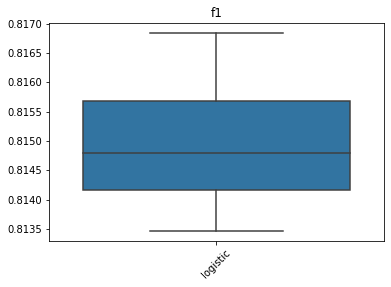

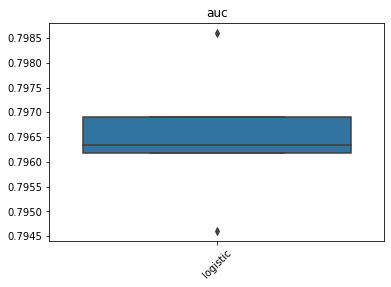

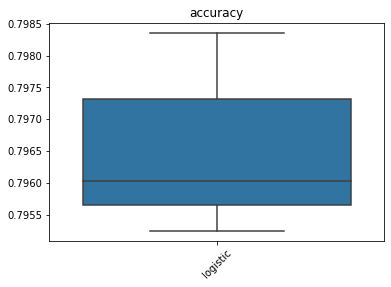

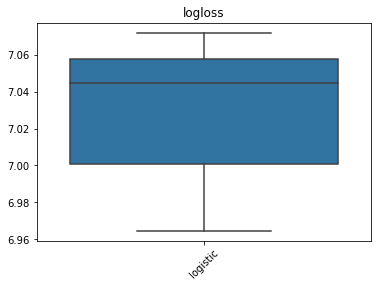

In [0]:
plot_estimators(['logistic'])


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


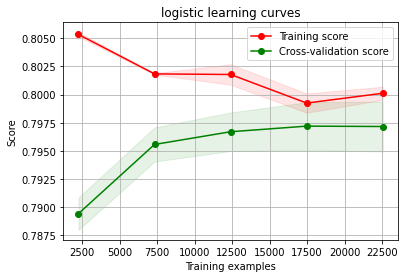

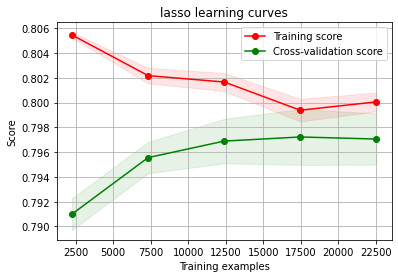

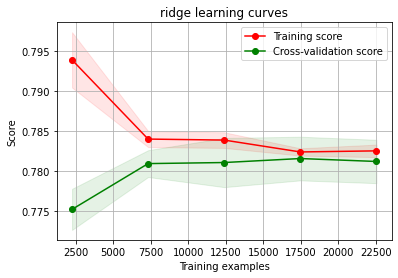

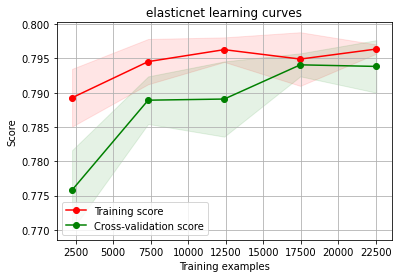

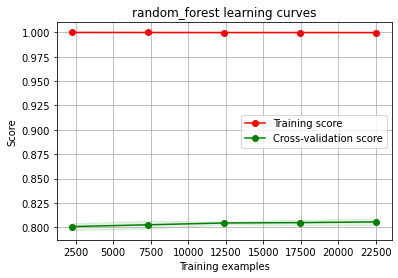

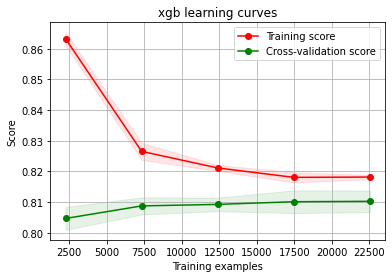

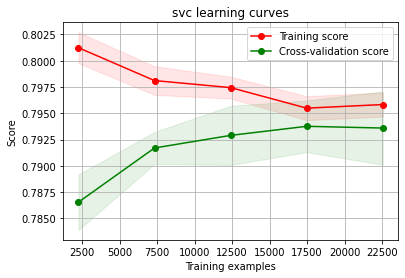

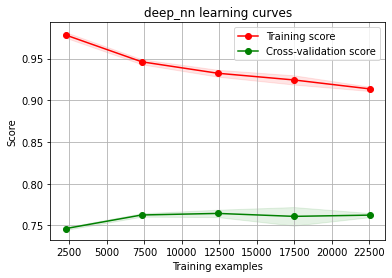

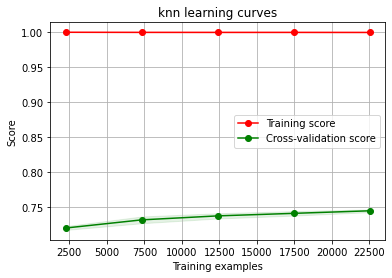

In [16]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

t=transformer
t.fit(X_train)
t=t.transform(X_train)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

to_plot=['logistic', 'lasso', 'ridge', 'elasticnet', 'random_forest','xgb','svc', 'deep_nn', 'knn']
for name in pipes.keys():
    if name in to_plot:
        g=plot_learning_curve(pipes[name].named_steps[name],name+' learning curves',t,y_train,cv=KFold(4),n_jobs=4)

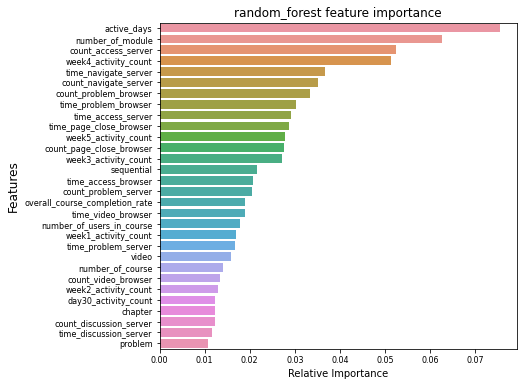

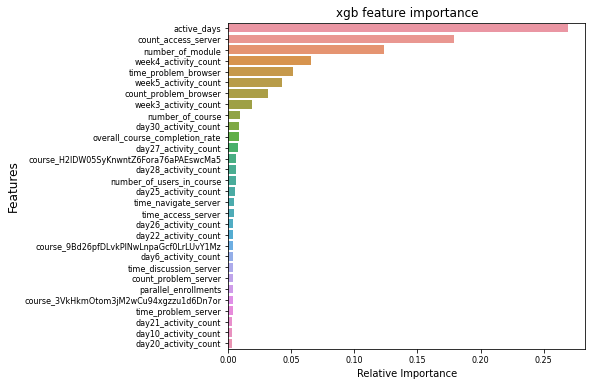

In [17]:
tree_based=['random_forest','xgb']
for name in pipes.keys(): 
    if name in tree_based:
        feat_impt=pipes[name].named_steps[name].feature_importances_
        graph_data=pd.DataFrame()

        graph_data['feature']=X_train.columns.values
        graph_data['importance']=feat_impt
        graph_data_top=graph_data.nlargest(30,'importance')

        plt.figure(figsize=(6.4,6))
        g=sns.barplot(y='feature',x='importance',data=graph_data_top,orient='h')
        g.set_ylabel('Features',fontsize=12)
        g.set_xlabel('Relative Importance')
        g.set_title(name + " feature importance")
        g.tick_params(labelsize=8)
        

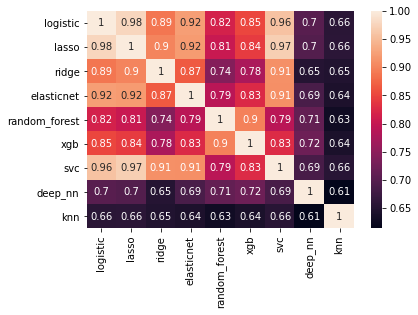

In [18]:
ensemble_results=pd.DataFrame()
for name,pipe in pipes.items():
    ensemble_results[name]=pipe.predict(X_test)
sns.heatmap(ensemble_results.corr(),annot=True)

In [0]:
del pipes['ridge'],pipes['lasso'],pipes['logistic']

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def print_predictions(target,predictions):
    print('auc: '+str(roc_auc_score(target,predictions)))
    print('accuracy: '+str(accuracy_score(target,predictions)))
    print('logloss: '+str(log_loss(target,predictions)))

    print(classification_report(target, predictions))


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


def draw_confusion_matrix(model, X_test, y_test):
  titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues,normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
  
  plt.show()

draw_confusion_matrix()

TypeError: ignored

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipes.values()] 
vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators))])
vote.fit(X_train,y_train)
predictions=vote.predict(X_test)

print_predictions(y_test,predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


auc: 0.793951822525967
accuracy: 0.8570774163994503
logloss: 4.936422203397908
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      4902
           1       0.92      0.90      0.91     19111

    accuracy                           0.86     24013
   macro avg       0.78      0.79      0.79     24013
weighted avg       0.86      0.86      0.86     24013



In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
def draw_roc_curve():
  count = 0
  svc_disp = None
  for pipe in pipes.values():
    if count == 0:
      svc_disp = plot_roc_curve(pipe.steps[1][1], X_test, y_test)
    else :
      ax = plt.gca()
      sub_disp = plot_roc_curve(pipe.steps[1][1], X_test, y_test, ax=ax, alpha=0.8)
      svc_disp.plot(ax=ax, alpha=0.8)
    count +=1

plt.show()

draw_roc_curve()

NameError: ignored

In [2]:
for name in pipes.keys():
    print(name)
    predictions=pipes[name].predict(test_features)
    print_predictions(y_test,predictions)
    print()

NameError: ignored

In [0]:
from itertools import combinations

final_estimators=['random_forest','xgb','deep_nn','elasticnet']

combos=[]
for L in range(2, len(final_estimators)+1):
    for subset in combinations(final_estimators, L):
        combos.append(list(subset))


combo_names=[]
auc=[]
f1=[]
logloss=[]
accuracy=[]

for combo in combos:
    estimators=[(name,clone(pipes[name].named_steps[name])) for name in combo] 
    vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators))])
    vote.fit(data,target)
    predictions=vote.predict(eval_data)

    auc.append(roc_auc_score(eval_target,predictions))
    accuracy.append(accuracy_score(eval_target,predictions))
    logloss.append(log_loss(eval_target,predictions))
    f1.append(f1_score(eval_target,predictions))
    combo_names.append(str(list(combo)))
    
score=pd.DataFrame()
score['combo']=combo_names
score['auc']=auc
score['f1']=f1
score['accuracy']=accuracy

score